# 序列到序列学习（seq2seq）

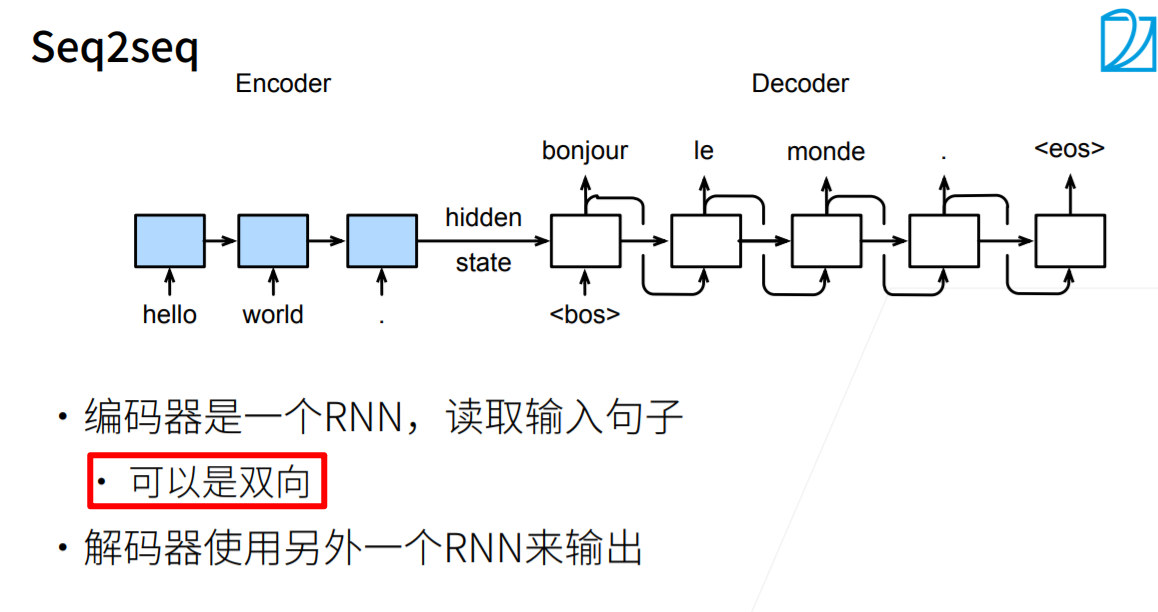
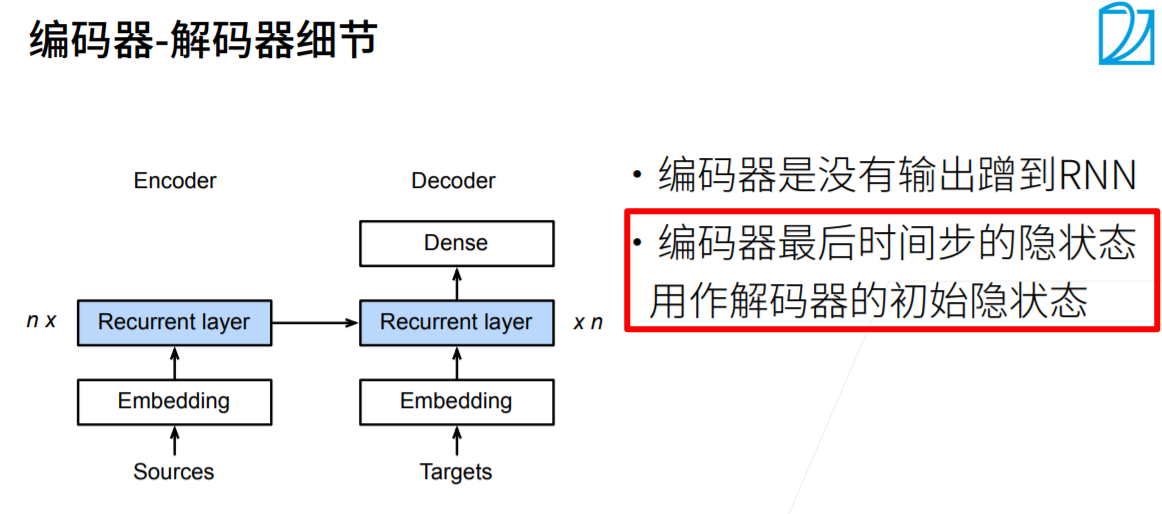
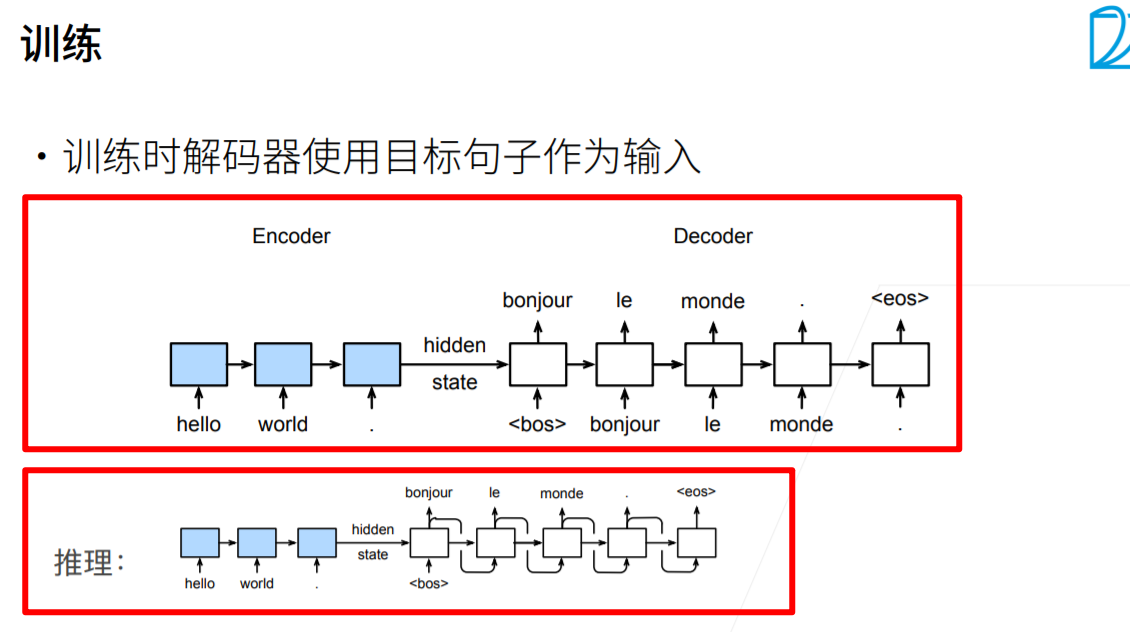

#### 机器翻译里面的评价指标呢？
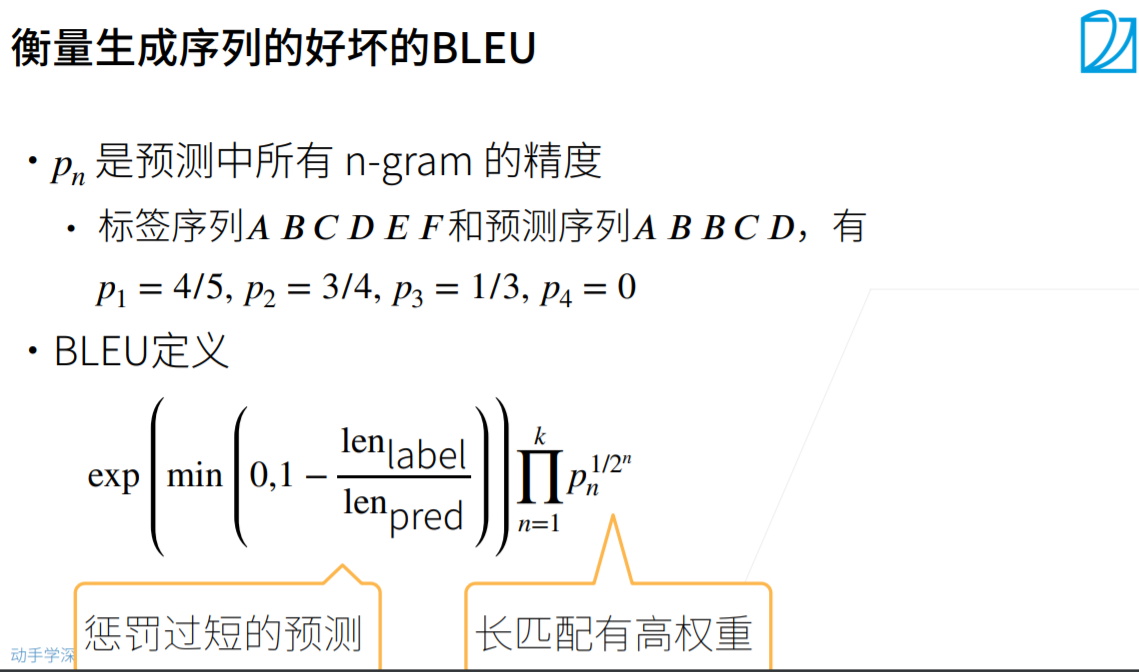

#### 注意上面的训练和推理：训练的解码器使用的是真实的标签序列；而推理的解码器使用的是解码器前一时刻的输出作为当前时刻的输入

In [1]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

#### 实现循环神经网络编码器

In [2]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        
        # 词嵌入，通俗来讲就是将文字转换为一串数字。
        # 第一个参数为：vocab_size，表示一共有多少个token；
        # 第二个参数为：embed_size，表示把每个token用词嵌入向量表示的大小，这里理解为特征的大小
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2) # [T, B, F]
        output, state = self.rnn(X)
        return output, state

#### 上述编码器的实现

In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape # [T, B, H]

torch.Size([7, 4, 16])

In [4]:
state.shape # [num_layer, B, H]

torch.Size([2, 4, 16])

#### 解码器

In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size) # 解码器有自己的embedding(标签序列转换成字典)
        # 解码器的输入embed_size + num_hiddens，这是因为：我们将当前的输入X和编码阶段的信息给串联起来了
        # embed_size为当前解码阶段的输入X的特征数（这个X为标签序列）；num_hiddens为编码器的隐藏状态大小
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size) # 解码阶段需要有输出（我们预测的）

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1] # 编码器的输出有两个：分别是output和state，这里指：把编码器的最后一个时刻的state，当作解码器的初始隐藏状态

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2) # X是指：标签序列。这里的操作是：将时间维度放最前面
        
        # 下面是decoder不一样的地方：
        # state[-1]就是最后一层的隐藏状态，然后把state[-1]重复X.shape[0]次，X.shape[0]就是输入序列的长度
        # 注意：这么做的原因是：我们认为最后一个隐藏层的隐藏状态，包含了前面所有隐层的隐藏状态的所有信息
        context = state[-1].repeat(X.shape[0], 1, 1)
        # 将前面的context和当前输入的X串联起来。这么做的原因是：
        # 我们认为当前的输出不仅和当前的输入有关，而且和编码器最后一层的隐藏状态有关
        X_and_context = torch.cat((X, context), 2)
              
        output, state = self.rnn(X_and_context, state) # 然后将X_and_context和隐藏状态state送入rnn（解码器最开始的state，就是编码器的输出state）
        output = self.dense(output).permute(1, 0, 2) # 通过一个全连接层得到输出，再把Batch_size放到最前面
        return output, state

#### 实例化解码器

In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
print(output.shape) # [4, 7, 10]->[B, T, vocab_size],vocab_size就是我们要预测的序列的长度
print(state.shape) # [2, 4, 16]->[num_layers, B, num_hiddens]

torch.Size([4, 7, 10])
torch.Size([2, 4, 16])


#### 通过零值化屏蔽不相关的项，怎么理解呢？
答：每个句子长度不一样，我们送入encoder时需要一样的长度啊，怎么办呢？那我们就人为定一个长度，则：比这个长度长的截断，短的就用一个指定的值填充

In [7]:
def sequence_mask(X, valid_len, value=0):
    """
    在序列中屏蔽不相关的项。
    X：输入的序列,[B, T, F],F为特征数，要是句子的话，就是embedding_size
    valid_len：每个句子真实的长度（因为不够的，我们用value给填充了）
    value=0：我们指定要填充的值，这里默认是0
    """
    maxlen = X.size(1) # 我们人为定义的，句子长度
    # 下面的操作是：生成0, 1,...,maxlen的序列。[None, :]操作是在0维度添加一个维度，[:, None]是在1维度添加一个维度
    # 然后比大小，这里使用了广播机制，按下面的例子：
    # tensor([[0., 1., 2.]]) < tensor([[1],[2]])的比较，其实就是：torch.tensor([[0., 1., 2.],[0., 1., 2.]]) < torch.tensor([[1, 1, 1],[2, 2, 2]])的比较
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value # True的地方保留，False的地方用value取代
    
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

#### 我们还可以使用此函数屏蔽最后几个轴上的所有项

In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

#### 通过扩展softmax交叉熵损失函数来遮蔽不相关的预测
因为填充的不需要做softmax运算

In [9]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""

    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label) # 生成全1的张量
        weights = sequence_mask(weights, valid_len) # 每个句子可用的保持1不变，不可用的变为0
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1) # 乘weights就是：为1的地方保持不变，0则相乘变成0
        return weighted_loss

#### 代码健全性检查

In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

#### 训练

In [11]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型。"""
    def xavier_init_weights(m): # 初始化模型参数
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights) # 应用初始化模型参数的函数
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # Adam优化器
    loss = MaskedSoftmaxCELoss() # 带掩码的 softmax交叉熵 损失函数
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1) # 给目标句子开头添加一个：开始标识符
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # 把开始标识符添加到decoder的输入里面
            Y_hat, _ = net(X, dec_input, X_valid_len) # 送入模型预测，得出预测结果
            l = loss(Y_hat, Y, Y_valid_len) # 计算损失
            l.sum().backward() # 反向传播求梯度
            d2l.grad_clipping(net, 1) # 梯度剪裁
            num_tokens = Y_valid_len.sum()
            optimizer.step() # 更新参数
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

#### 创建和训练一个循环神经网络“编码器－解码器”模型

loss 0.020, 15729.7 tokens/sec on cuda:0


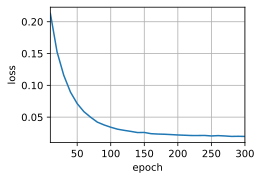

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout) # 得到编码器对象
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout) # 得到解码器对象
net = d2l.EncoderDecoder(encoder, decoder) # 定义模型对象
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device) # 训练

#### 预测
预测和训练不一样：我们在训练的时候，解码器每次的输入是真实的标签序列，而在预测的时候，没有标签，因此，我们使用上一时刻的预测值作为当前时刻的输入

In [13]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0) # encoder的输入
    enc_outputs = net.encoder(enc_X, enc_valid_len) # encoder的输出
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len) # decoder的初始隐藏状态
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),dim=0) # decoder的输入
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2) # 将预测值作为decoder的输入
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']: # 遇到句子的结束符，则生成单词结束
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

#### BLEU的代码实现

In [14]:
def bleu(pred_seq, label_seq, k):  
    """计算 BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

#### 将几个英语句子翻译成法语

In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu est occupé ., bleu 0.548
he's calm . => il est bon court ., bleu 0.548
i'm home . => je suis chez moi <unk> ., bleu 0.803


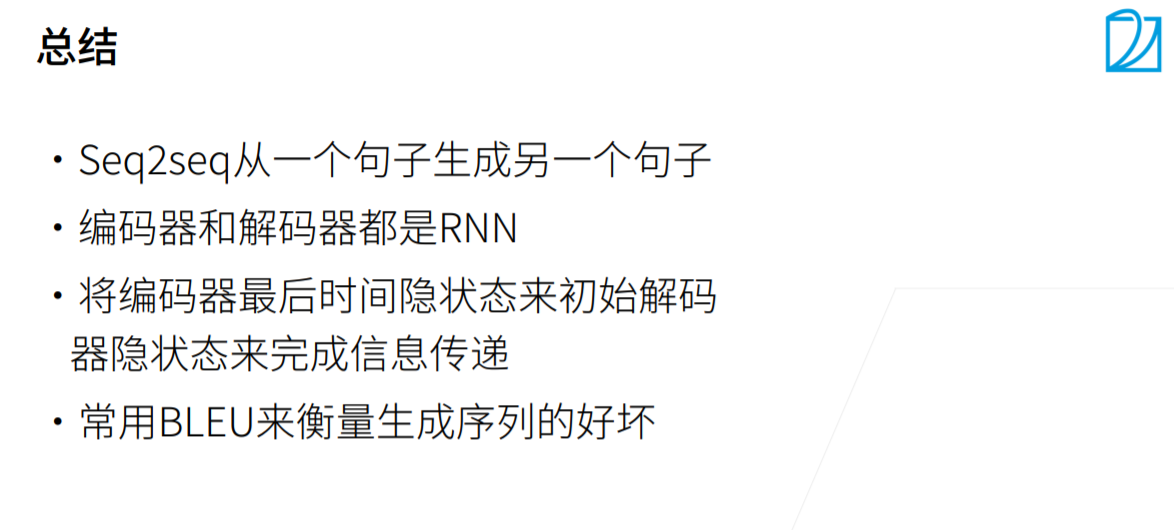